# 🔍 Jury Deliberation Simulator

Ever watched 12 Angry Men and wondered what really happens in that jury room? 🤔

How do strangers wrestle with facts, biases, and pressure to reach a unanimous verdict?

⸻

# 🎯 Our Goal

We built an interactive jury deliberation simulator using Python and Google Gemini AI

Not just another chatbot—but an exploration into whether Generative AI can realistically capture the messy dynamics of human jury deliberation.

⸻

# ⚖️ The Case Setup

You’re Juror #4 in a murder trial:

	•	Defendant: Jack Miller, 18, accused of killing Leo Briggs
	•	Murder weapon: Jack’s knife, but only victim’s prints found
	•	Shoe prints at scene match Kai (Jack’s rival), who also had motive
	•	Jack’s digital alibi exists—but no eyewitness

The evidence is ambiguous, packed with reasonable doubt.

⸻

# 🧠 Simulation Modes

You can choose how your AI jury is assembled:

	•	Scripted Mode

Clearly defined jurors with fixed personas (stored in SCRIPTED_JURORS_DATA)

Perfect for controlled tests or repeatable experiences

	•	Generated Mode

Jurors dynamically generated by AI (generate_jurors()), creating new personalities every run

Ideal for replayability and exploring unpredictable group dynamics

All jurors are guided by a shared behavioral framework (JUROR_TEMPLATE) to ensure consistency.

⸻

# 🛠️ Technical Overview

### 💬 LLM-Powered AI Agents

Agents created using LangChain + Google Gemini 2.0 (Flash)

Each juror is semi-autonomous, making decisions based on:

	•	Personal biases and persona traits
	•	Complete deliberation history (stored transcript)
	•	Context-aware LLM prompting to guide responses

### 🔄 Core Gameplay Loop (run_game())

The gameplay alternates between:

	•	AI jurors taking turns speaking or responding
	•	Player’s actions, including:
	•	Speaking to influence deliberation
	•	Skipping a turn
	•	Initiating voting to reach a verdict
	•	Exiting deliberation (available after 2 voting rounds)

Gameplay ends when:

	•	A unanimous verdict is reached (Guilty or Not Guilty)
	•	Player chooses to exit
	•	A hung jury occurs (no unanimous decision after votes)

### 🧠 Designing Juror Behavior

Each AI juror’s actions are shaped by:

	•	Detailed persona descriptions (static or AI-generated)
	•	Memory of previous arguments and interactions
	•	Structured AI prompts to ensure logical, consistent dialogue

### 📈 Player Performance Evaluation

After deliberation ends:

	•	The entire conversation and rubric criteria are analyzed by Gemini AI
	•	The player receives:
	•	Five performance insights highlighting strengths and areas for improvement
	•	An overall score out of 100
	•	Optional recommendations for better performance in future simulations

⸻


# 🚀 Future Directions

Exciting expansions under consideration:

	•	Adding visual evidence like crime-scene photos
	•	Allowing players to take the role of lawyers, presenting evidence to AI jurors
	•	Creating smarter, emotionally intelligent AI jurors who form alliances or rivalries
	•	Developing a web-based UI or open API for educational and research purposes

### LLM Jury Simulation Flowchart

This diagram illustrates a courtroom simulation system powered by multiple LLM agents as jurors. Each juror votes and speaks based on case notes, while a human player interacts with them. The system initializes with agent personalities, facilitates dynamic dialogues, and concludes with a summary based on collective verdicts and reasoning scores.

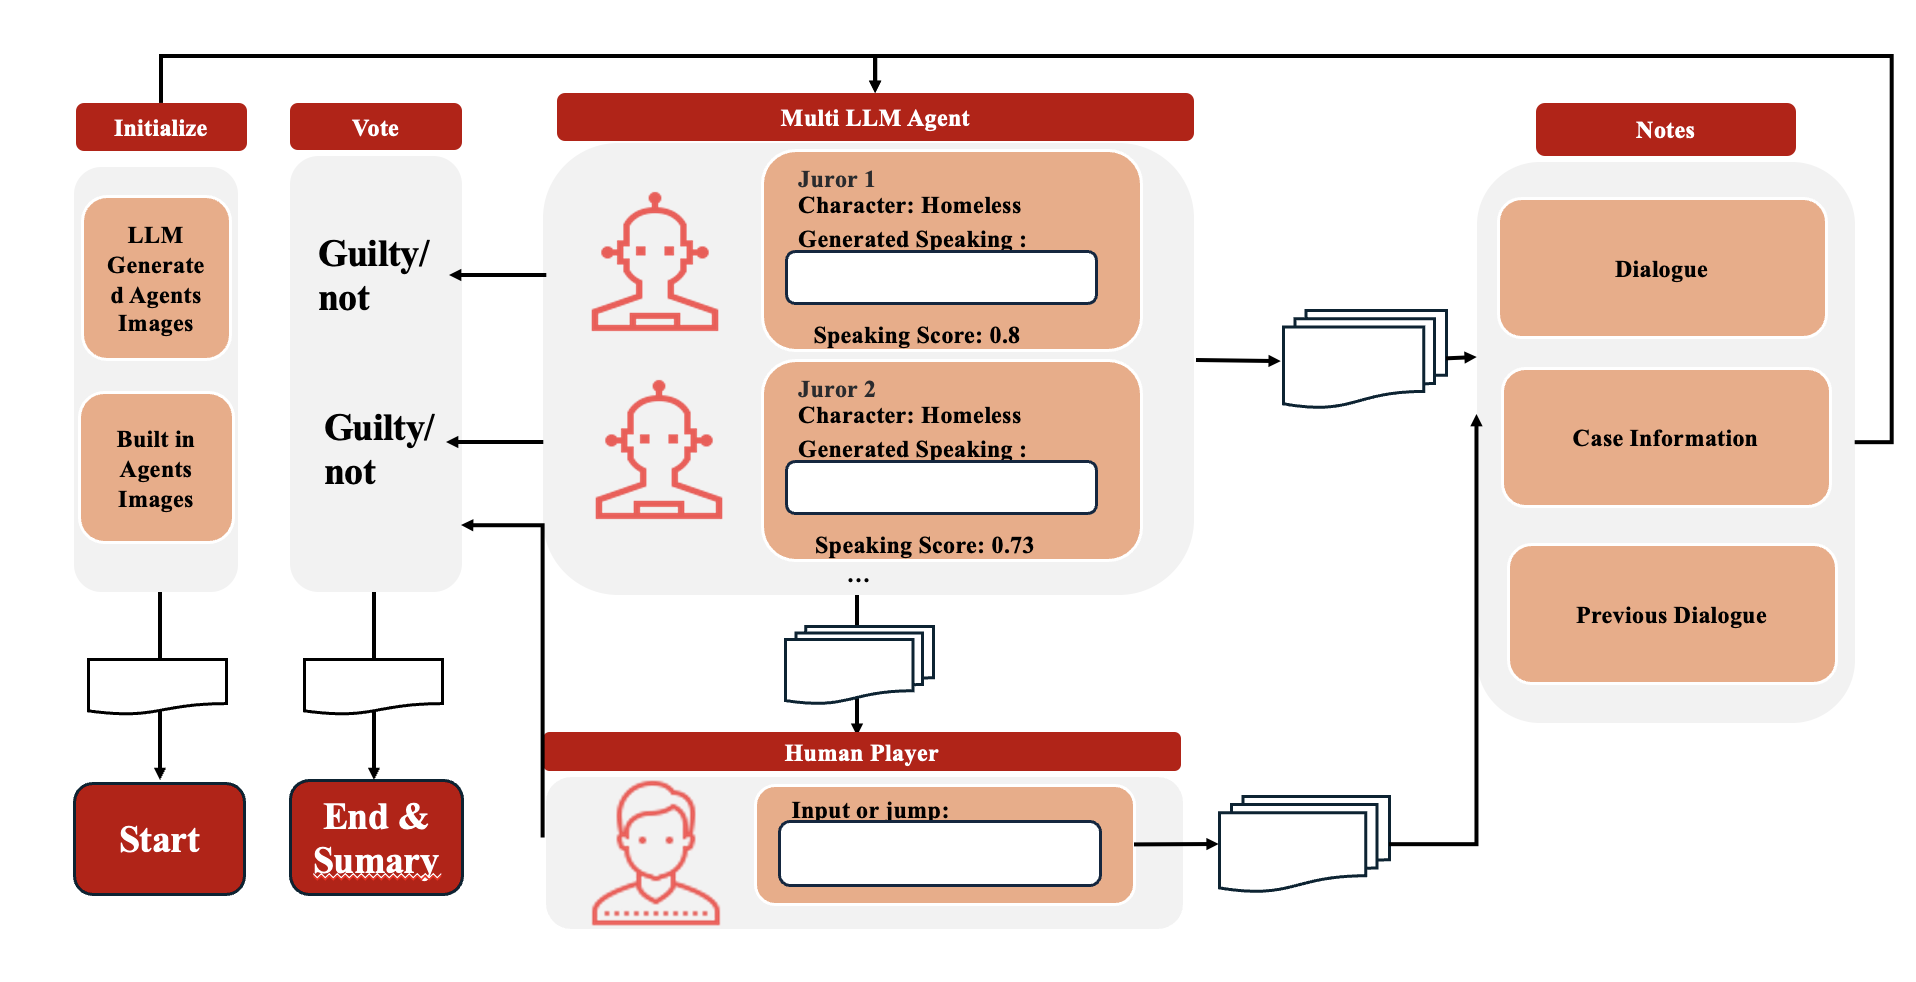

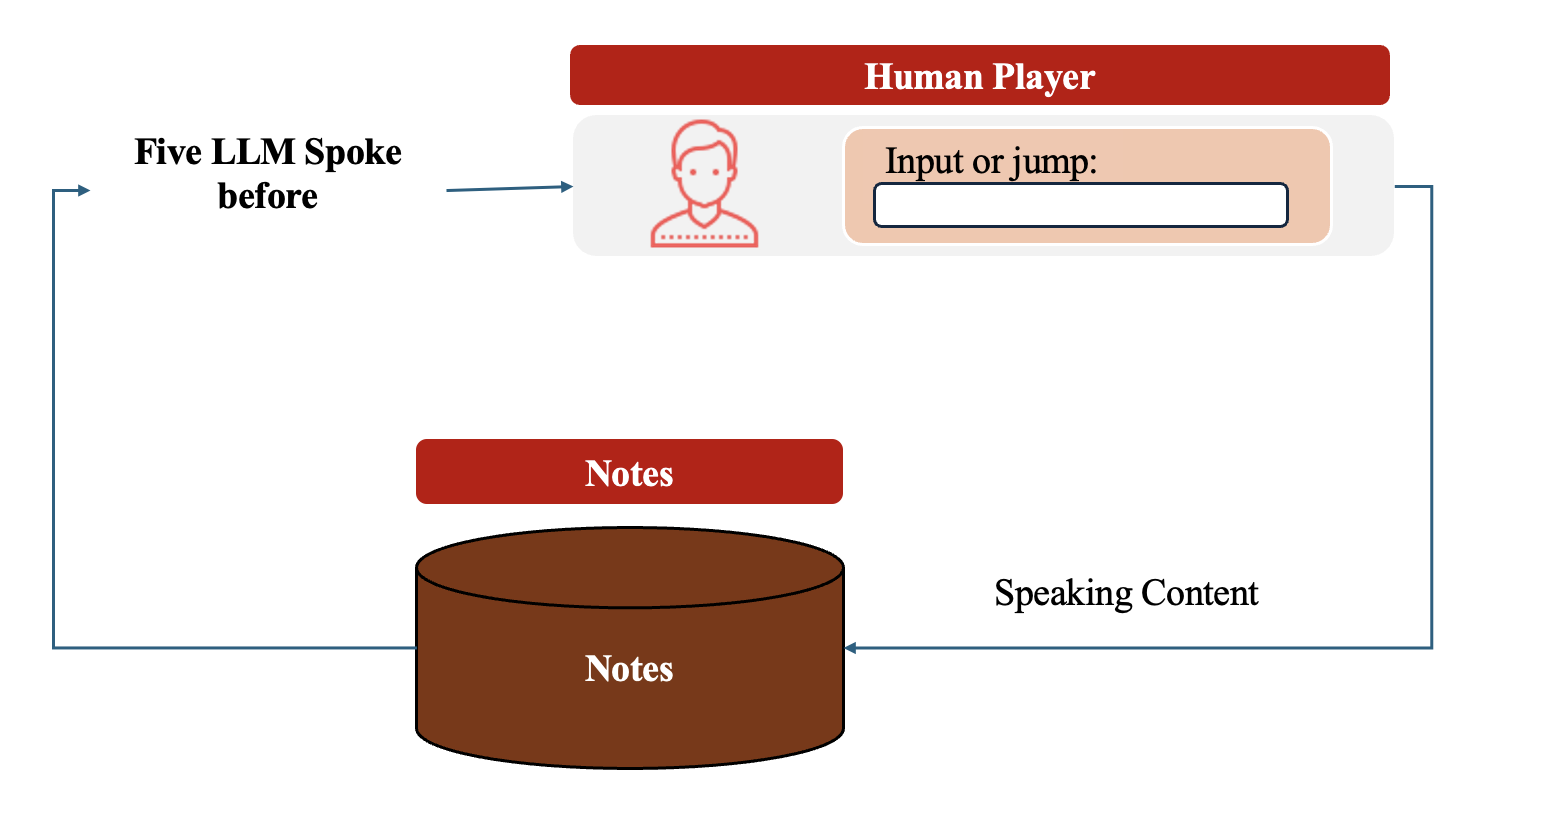

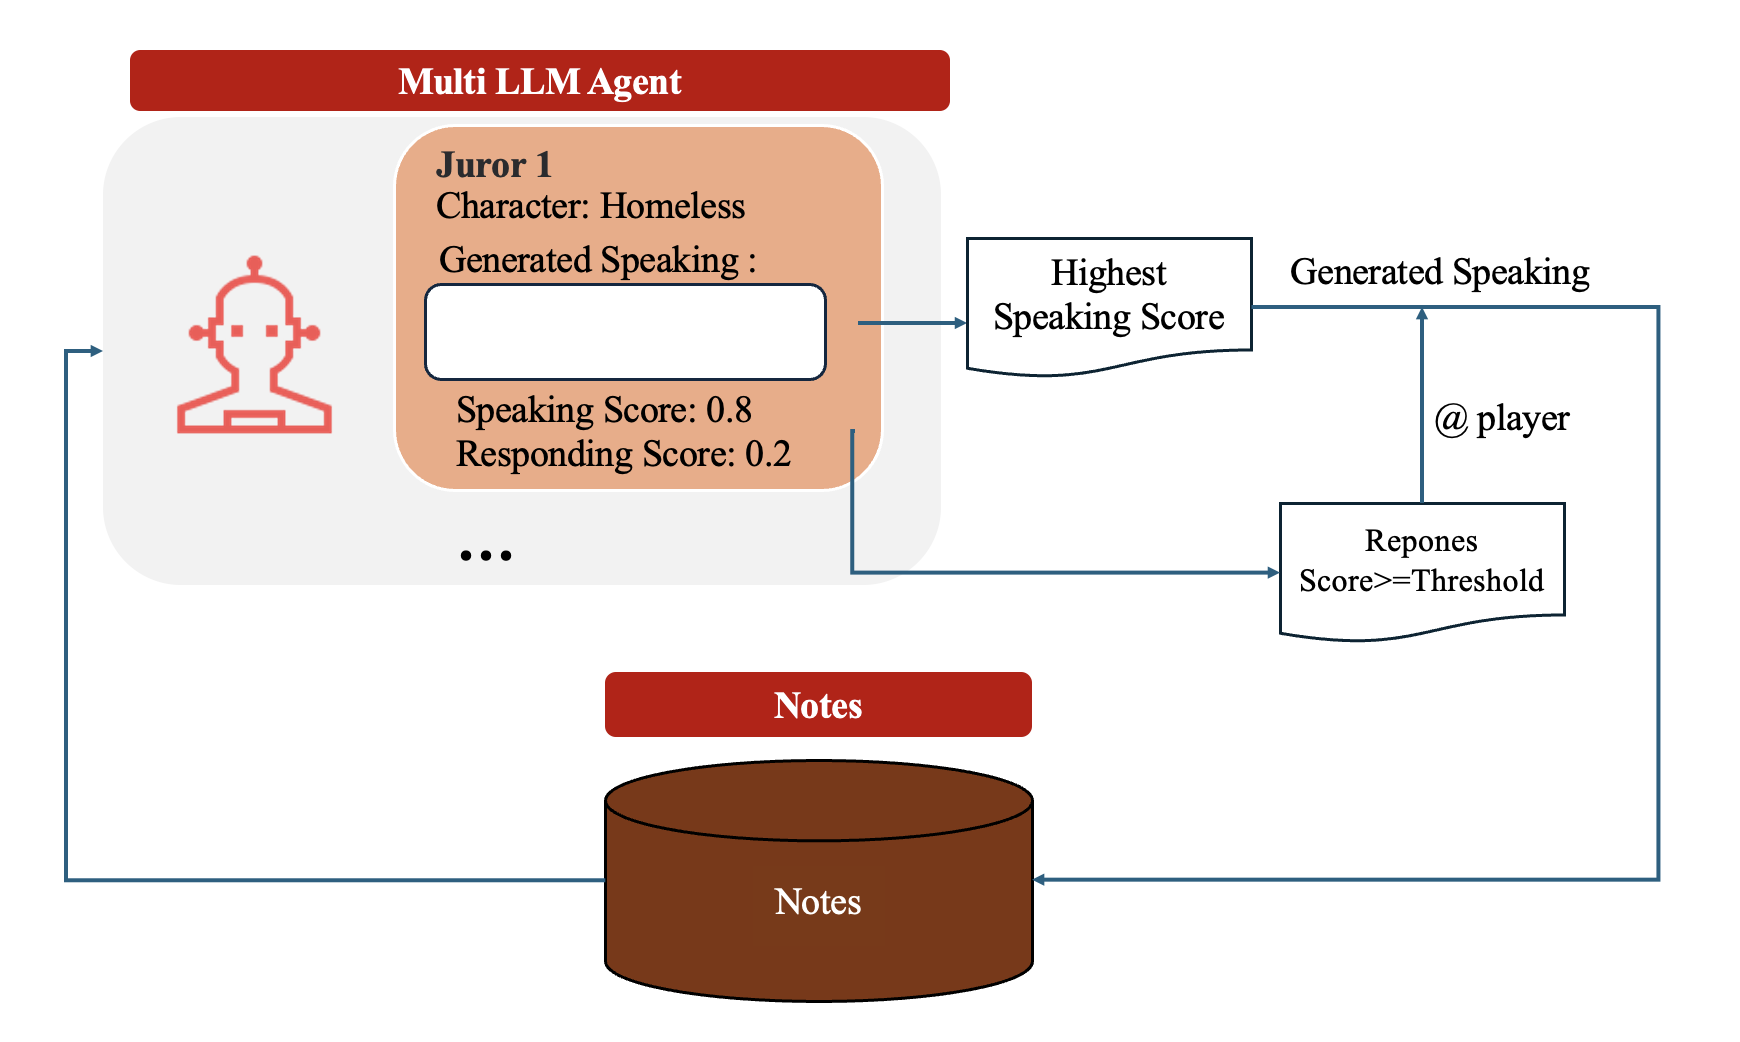

Step 1: Enviroment and API set up

In [1]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.9/433.9 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 10.4 MB/s eta 0:00:00


In [2]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [3]:
# LLM set up
import random
import re
# Added for time delays
import time 
from typing import Dict, List, Any, TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

try:
    # llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=GOOGLE_API_KEY)
    llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash") 
    print("LLM Initialized Successfully.")
except Exception as e:
    print(f"Error initializing LLM: {e}")
    print("Please ensure your Google API key is configured correctly.")
    llm = None # For notebook demonstration purposes, set to None if failed

if llm:
    print(f"Using LLM Model: {llm.model}")

LLM Initialized Successfully.
Using LLM Model: models/gemini-1.5-flash


**Step 2: Defining Constants - Rubric & Case Facts**

We define two important constant strings. *PERFORMANCE_RUBRIC* outlines how the player's (your) participation will be evaluated at the end of the simulation. *CASE_FACTS* contains all the stipulated evidence and background information about the murder case that the jurors must use for their deliberation.

In [4]:
    # Rubric for player performance evaluation
    PERFORMANCE_RUBRIC = """
    Objective Evaluation Rubric:
    1.  **Engagement & Participation:** How actively did the player (Juror 4) participate? Were their contributions timely and relevant to the ongoing discussion?
    2.  **Evidence-Based Reasoning:** Did the player primarily use the provided Case Facts to support their arguments? Did they reference specific pieces of evidence or inconsistencies?
    3.  **Logical Consistency:** Was the player's reasoning clear and consistent? Did they avoid major contradictions in their statements?
    4.  **Influence & Interaction:** Did the player effectively respond to other jurors' points? Did their arguments seem to influence the deliberation? Did they ask clarifying questions?
    5.  **Overall Contribution:** How significantly did the player contribute to the depth and direction of the deliberation towards resolving the case based on the evidence?
    """

    # Case facts
    CASE_FACTS = """
    SCENE (Objective version)
    A present-day suburban college town in early spring.

    Jack Miller, 18 years old, is on trial for the murder of his classmate Leo Briggs, also 18. Leo—
    heir to a large trust fund—was found three days after friends lost contact with him, seated against
    his bedroom desk with a single stab wound to the chest.

    The jurors have just been escorted into a plain, windowless deliberation room to reach a
    unanimous verdict of Guilty (Jack is the killer) or Not Guilty (reasonable doubt remains).
    Nobody—inside or outside the room—truly knows what happened that night.

    FACTUAL RECORD (stipulated by both sides)

    1. Murder weapon - A personal fixed-blade knife engraved with a jasper-stone inlay—an
    heirloom gift from Jack's grandmother. Kai Sato, a rival from another school, was
    seen flaunting the knife weeks earlier after snatching it from Jack during an in-class
    altercation. No fingerprints were found. Only Leo's fingerprints were found on the
    handle and blade; no blood, prints, or DNA from Jack (or anyone else) appeared.

    2. Timeline
       o Day -3 (7:14 p.m.) Neighbor Mrs Nguyen heard shouting, a shattering sound,
         then silence from Leo's apartment.
       o She glimpsed a figure matching Jack's build and school jacket exiting by the back
         stairwell.
       o Day 0 (noon) Police performed a wellness check at Leo's father's request and
         discovered the body. Medical examiner fixes time-of-death between Day -3
         9 p.m. and Day -2 4 a.m.

    3. Known conflicts
       o Leo bullied Jack for ~3 years (shoves, humiliating pranks, public ridicule).
       o Kai said Leo exchanged violent threats and fought twice on record; Kai wears
         size-10 Nike Air trainers matching bloody shoeprints at the scene, but claims he
         gave them away last month.

    4. Possible alibi - Jack's cell-tower data and home-router logs place his phone at his
       apartment from Day -3 7 p.m. forward; he lives alone after 5 p.m. on weekdays; no
       witness can confirm.

    5. Social context - Leo was broadly disliked; teachers documented two prior suspensions
       but no recent incidents.

    6. Forensics - No forced entry. One set of bloody shoeprints (size 10 Nike Air) led from
       bedroom to kitchen sink. Jack wears size 9 Vans. Knife had only Leo's prints and trace of
       Kai's cologne in the leather sheath, according to lab GC-MS report.

    7. Motive theories
       o Revenge/self-defense by Jack.
       o Setup by Kai, using the very knife he stole.
    """

We define structures to hold information about each juror. The JUROR_TEMPLATE is a string template used to instruct the LLM on how to behave as a specific juror, incorporating their persona, personality, and current state. The JurorState TypedDict provides a clear structure for storing the attributes of each juror (like their persona, personality, scores, current vote, and internal thoughts).

**Step 3: Defining Juror Structure**

We define structures to hold information about each juror.

- `JUROR_TEMPLATE` is a string template used to instruct the LLM on how to behave as a specific juror. It incorporates their **persona**, **personality**, and **current state**.

- `JurorState` (a `TypedDict`) provides a clear structure for storing the attributes of each juror, such as:
  - `persona`
  - `personality`
  - `scores`
  - `current vote`
  - `internal thoughts`

In [5]:
    # Step 3: Define Juror Template and State Structure

    JUROR_TEMPLATE = """You are Juror #{juror_id}, participating in a murder trial deliberation.
    Your persona and background:
    {persona}

    Your personality, biases, and initial leanings:
    {personality}

    You should stay in character and be consistent with your persona. When discussing the case, 
    base your reasoning on the evidence and your persona's perspective.

    Current verdict leaning: {initial_leaning}

    IMPORTANT: Speak naturally as if in a real conversation. Use casual language, verbal fillers,
    and conversational expressions. Show emotion and reactivity to others' points. Interrupt your thoughts
    occasionally, use incomplete sentences, and speak with the natural flow of a real person in a heated 
    jury deliberation.

    Important rules:
    1. Speak in first person as your character, use "I" statements
    2. Reference your background and experiences when relevant
    3. Don't be omniscient - only know what was presented in the case
    4. You can change your mind based on the deliberation, but do so in a way consistent with your persona
    5. Your speaking_score is currently {speaking_score} and your responding_score is {responding_score}
    """

    # Define data structures
    class JurorState(TypedDict):
        persona: str
        personality: str
        initial_leaning: str
        speaking_score: float
        responding_score: float
        current_vote: str
        internal_thinking: str

    print("Juror Template and State Structure Defined.")

Juror Template and State Structure Defined.


**Step 4: Defining Scripted Juror Data**

The simulation  allows using predefined "scripted" jurors instead of generating them dynamically (both type is realized in our game).

- `SCRIPTED_JURORS_DATA` is a dictionary that holds the detailed:
  - **persona**
  - **personality**
  - **initial leaning**  

  for five specific AI jurors: **Jurors 1, 2, 3, 5, and 6**.

- **Juror 4** is reserved for the player.

In [6]:
    # Step 4: Define Scripted Juror Data

    SCRIPTED_JURORS_DATA = {
        "Juror_1": {
            "persona": "Early-40s, athletic build, charcoal three-piece suit tailored to perfection. Platinum chrono-watch; manicured nails; hair slicked straight back. Checks phone every three minutes, taps a Montblanc pen in bursts of four, straightens tie whenever poverty is mentioned.",
            "personality": "Grew up in a collapsing mill town sharing a single room with two siblings. At fifteen, he bloodied a bully with a pocketknife and was suspended—but local police quietly dropped charges after his mother begged the sheriff. He now bankrolls start-ups and equates success with domination. \"Knife's his—case closed. Let's vote and get dinner.\" Unique Experience: The weapon being an heirloom knife rattles him: he still carries *his* grandfather's knife as a reminder of \"earning respect.\" He fears sentimentality weakens judgment—so he doubles down on \"facts\" (ownership = guilt).",
            "initial_leaning": "Guilty"
        },
        "Juror_2": {
            "persona": "Late-60s, broad-shouldered, grease-stained cuticles despite pressed flannel shirt. Worn denim jacket over prison-issue gray sweater; old tattoo peeks from left wrist. Counts points on callused fingers, breathes out slowly before speaking.",
            "personality": "Wrongly convicted of a bar-fight homicide in 1979; DNA cleared him after 30 years. Now a volunteer driver for an innocence-project clinic, lives off modest restitution and social security. Speaks softly, trusts data not \"gut.\" \"Seen railroads to prison before. Prints—or the lack—matter.\" Unique Experience: The same detective who botched his case led the first 48 hours of Leo's investigation. Hearing that name in testimony set off visible tremors in his hand—and a vow not to let haste cage another kid.",
            "initial_leaning": "Not Guilty"
        },
        "Juror_3": {
            "persona": "Early-20s, slim, emerald under-dye under sleek bob, blazer over graphic tee. Stainless-steel fidget ring; rapid-fire note-taking on tablet; bounces foot to lo-fi beats through one earbud.",
            "personality": "Endured relentless cyber-bullying in high school; channelled pain into coding an anti-bully support app that later won a state prize. Now interning at a fintech start-up. Advocates evidence-based empathy. \"Bullying pushes people, but evidence gaps are huge.\" Unique Experience: In sophomore year, a tormentor stole the multitool her late aunt left her; school admin shrugged. She hears Jack's \"stolen gift\" story and feels a surge of déjà vu—yet she refuses to ignore forensics because \"feelings fooled me once.\"",
            "initial_leaning": "Undecided"
        },
        # Juror 4 is the human player
        "Juror_5": {
            "persona": "Early-50s, warm brown eyes behind square spectacles on a beaded chain. Tweed jacket with elbow patches, canvas satchel stuffed with spiral pads. Post-its marking DSM entries. Hums classical motifs while jotting, taps glasses against lips when statistics are cited.",
            "personality": "Doctorate in Educational Psychology; researches adolescent aggression and the bystander effect. Consults for school districts on anti-bullying programs. Lost a Ph.D. advisee in a dorm-room stabbing ten years ago; testified in that case. \"System failed all these kids. Must be guided by doubt, not grief.\" Unique Experience: Conducted climate surveys at Jack & Leo's high school last year. Her raw data (sealed under IRB) showed a spike in unreported bullying of \"academically gifted but introverted\" students. She wrestles with whether to disclose that insight or keep the deliberations strictly to admitted evidence.",
            "initial_leaning": "Not Guilty"
        },
        "Juror_6": {
            "persona": "Late-30s, thrift-store navy blazer a size large, paisley tie borrowed from a shelter donation bin. Scuffed loafers with taped insoles; fingerless gloves shoved into pocket; sharp walnut-brown eyes scan every corner. Folds scrap paper into tiny origami cranes during lulls; pockets extra courthouse biscuits.",
            "personality": "Former corner-store owner who lost everything after a medical bankruptcy. Living rough for two years but spends nights in the public library reading true-crime and case law. Fiercely protective of underdogs. \"Jackets swap easy. Eyewitnesses see what they expect.\" Unique Experience: Two years ago his teenage son was arrested for shoplifting a designer jacket the father had actually stolen. CCTV cleared the boy, exposing how quick ID's can fail. That memory resurfaces when he hears the neighbor's \"school-jacket\" testimony—and when he notices his own shoes match the size-10 Nike Air prints the prosecution waved around.",
            "initial_leaning": "Not Guilty"
        }
    }
    print("Scripted Juror Data Defined.")

Scripted Juror Data Defined.


In [7]:
    print("--- Sample Scripted Juror (Juror_1) ---")
    import json
    print(json.dumps(SCRIPTED_JURORS_DATA["Juror_1"], indent=2))

--- Sample Scripted Juror (Juror_1) ---
{
  "persona": "Early-40s, athletic build, charcoal three-piece suit tailored to perfection. Platinum chrono-watch; manicured nails; hair slicked straight back. Checks phone every three minutes, taps a Montblanc pen in bursts of four, straightens tie whenever poverty is mentioned.",
  "personality": "Grew up in a collapsing mill town sharing a single room with two siblings. At fifteen, he bloodied a bully with a pocketknife and was suspended\u2014but local police quietly dropped charges after his mother begged the sheriff. He now bankrolls start-ups and equates success with domination. \"Knife's his\u2014case closed. Let's vote and get dinner.\" Unique Experience: The weapon being an heirloom knife rattles him: he still carries *his* grandfather's knife as a reminder of \"earning respect.\" He fears sentimentality weakens judgment\u2014so he doubles down on \"facts\" (ownership = guilt).",
  "initial_leaning": "Guilty"
}


**Step 5: Chat Record Class**

The *ChatRecord* class is responsible for recording history of the deliberation. It stores the transcript of *messages* (who said what, when, and optionally, who they were responding to or what their vote was) and keeps track of the current votes. 

It also includes a *counter* for messages exchanged since the player last spoke, used to prompt the player for input. The *format_history* method prepares the transcript into a readable string format suitable for inclusion in LLM prompts

In [8]:
    # Step 5: Chat Record Class Definition

    class ChatRecord:
        def __init__(self):
            self.transcript = []
            self.votes = {}
            self.messages_since_player_input = 0
        
        def add_message(self, speaker, content, responding_to=None, vote=None, turn=0):
            """The add_message method adds a message to a conversation transcript, 
            while also tracking speaker identity, vote actions, and how many AI messages 
            have occurred since the player last interacted.."""
            message = {
                "speaker": speaker,
                "content": content,
                "turn": turn
            }
            if responding_to:
                message["responding_to"] = responding_to
            if vote:
                message["vote"] = vote
                self.votes[speaker] = vote 
            
            self.transcript.append(message)
            
            # Increment counter only if an AI juror speaks/votes
            # "Player" is the identifier for the human player
            if speaker != "Player": 
                self.messages_since_player_input += 1
                
            # Reset counter if the player speaks/votes
            else: 
                 self.messages_since_player_input = 0
                
            # Return the updated message dict
            return message 
        
        def format_history(self):
            """Formats the chat history into a string for LLM prompts."""
            formatted = ""

            # iterating into transcript and save them into `formatted` with format
            for entry in self.transcript:
                prefix = f"{entry['speaker']}"
                details = []
                if "responding_to" in entry:
                    details.append(f"responding to {entry['responding_to']}")
                if "vote" in entry:
                    details.append(f"VOTES {entry['vote']}")
                
                if details:
                    prefix += f" ({', '.join(details)})"
                
                formatted += f"{prefix}: {entry['content']}\n\n"
            return formatted.strip() # Remove trailing newlines

    print("ChatRecord Class Defined.")

ChatRecord Class Defined.


In [9]:
    print("--- ChatRecord Demo ---")
    demo_chat = ChatRecord()
    demo_chat.add_message(speaker="Juror_1", content="Let's get started. I think he's guilty.", turn=1)
    demo_chat.add_message(speaker="Juror_2", content="Hold on, let's look at the evidence first.", turn=2, responding_to="Juror_1")
    demo_chat.add_message(speaker="Player", content="I agree, we need to be careful.", turn=3, responding_to="Juror_2")
    demo_chat.add_message(speaker="Juror_1", content="Fine, but the knife...", turn=4, responding_to="Player")
    demo_chat.add_message(speaker="Juror_5", content="The knife had Kai's cologne trace, remember?", turn=5)
    demo_chat.add_message(speaker="Juror_1", content="He still owned it!", vote="Guilty", turn=6)


    print("Formatted History:\n")
    print(demo_chat.format_history())
    print(f"\nMessages since player input: {demo_chat.messages_since_player_input}")
    print(f"Current Votes: {demo_chat.votes}")

--- ChatRecord Demo ---
Formatted History:

Juror_1: Let's get started. I think he's guilty.

Juror_2 (responding to Juror_1): Hold on, let's look at the evidence first.

Player (responding to Juror_2): I agree, we need to be careful.

Juror_1 (responding to Player): Fine, but the knife...

Juror_5: The knife had Kai's cologne trace, remember?

Juror_1 (VOTES Guilty): He still owned it!

Messages since player input: 3
Current Votes: {'Juror_1': 'Guilty'}


**Step 6: Jury Game Class** - Initialization (__init__)


This is the main class orchestrating the simulation. The __init__ method sets up the game state. It initializes an empty dictionary *self.jurors* to hold the JurorState for each AI juror, creates a *ChatRecord* instance, sets the starting *turn* number, and initializes various flags (like *vote_initiated*, *awaiting_player_input*, *final_verdict_reached*). Crucially, it prompts the user (in a real run) to choose between 'generated' or 'scripted' AI jurors and calls the appropriate method (generate_jurors or initialize_scripted_jurors) to populate self.jurors. It includes fallback logic to create default jurors if initialization fails. Finally, it prints the case facts and summaries of the chosen AI jurors.

In [10]:
    # Step 6: Jury Game Class - Initialization

    class JuryGame:
        def __init__(self):
            self.jurors: Dict[str, JurorState] = {} 
            self.chat = ChatRecord()
            self.current_turn = 1
            self.vote_initiated = False
            self.awaiting_player_input = False
            self.player_juror_id = "Juror_4" # human player juror ID
            self.first_vote_happened = False # Flag to ensure first vote isn't unanimous
            self.vote_round_count = 0 # Track number of voting rounds
            self.player_exited = False # Flag if player chooses to exit
            self.final_verdict_reached = False # Flag if a unanimous verdict was reached

            print("\nWelcome to the Jury Deliberation Simulation.")
            print("Case: Jack Miller murder trial")
            print("You will participate as Juror🧑‍⚖️ #4.")
            
            juror_choice = ""
            while juror_choice not in ['generated', 'scripted']:
                 juror_choice = input("Choose AI juror companions: type 'generated' or 'scripted': ").lower().strip()
                 if juror_choice not in ['generated', 'scripted']:
                     print("Invalid choice. Please type 'generated' or 'scripted'.")
    

            if juror_choice == 'generated':
                 print("\nGenerating 5 diverse AI juror personas...")
                 if llm: # Only attempt if LLM initialized
                     self.generate_jurors(number_of_jurors=5) 
                 else:
                     print("LLM not available, cannot generate jurors.")
            else: # scripted
                 print("\nInitializing 5 scripted AI juror personas...")
                 self.initialize_scripted_jurors()
            
            # Ensure at least 5 AI jurors exist after choice
            if len(self.jurors) < 5:
                print('1')
                print('len(self.jurors)',len(self.jurors))
                print("Juror initialization failed or insufficient jurors created, creating default jurors...")
                # Clear any partial list before creating defaults
                self.jurors.clear() 
                # Create 5 default AI jurors (IDs 1, 2, 3, 5, 6 to match scripted pattern)
                default_ids = ["Juror_1", "Juror_2", "Juror_3", "Juror_5", "Juror_6"]
                for i, juror_id in enumerate(default_ids):
                     # Use the previously defined TypedDict for structure
                    self.jurors[juror_id] = JurorState(
                        persona=f"Default background for juror {i+1}.",
                        personality=f"Default personality traits for juror {i+1}.",
                        initial_leaning="Undecided",
                        # initialized as random
                        speaking_score=random.uniform(70, 90),
                        responding_score=random.uniform(70, 90),
                        current_vote="Undecided",
                        internal_thinking=""
                    )
                print(f"Created {len(self.jurors)} default jurors.")
            
            # self.chat.votes will be populated during handle_voting
    
            print("\nJury simulation initialized.")
            print("\n" + "="*50 + "\nCASE FACTS\n" + "="*50)
            print(CASE_FACTS)
            print("\n" + "="*50 + "\nAI JUROR INFORMATION\n" + "="*50)
            # Print info only for the 5 AI jurors
            for juror_id, juror in self.jurors.items():
                # No need to check player_juror_id here, it's not in self.jurors
                print(f"{juror_id}:")
                print(f"  Background: {juror['persona'][:100]}...") # Truncate for brevity
                print(f"  Personality: {juror['personality'][:100]}...") # Truncate for brevity
                print(f"  Initial leaning: {juror['initial_leaning']}")
                print("-"*30)
        
        
        def initialize_scripted_jurors(self): pass
        def generate_jurors(self, number_of_jurors=5): pass
        def determine_responding_juror(self): pass
        def juror_responds(self, juror_id): pass
        def determine_speaking_juror(self): pass
        def juror_speaks(self, juror_id): pass
        def handle_voting(self): pass
        def player_action(self, player_response): pass
        def check_player_input_needed(self): pass
        def display_player_hints(self): pass
        def generate_game_summary(self): pass
        def run_game(self): pass


    print("JuryGame Class Defined (Initialization Part).")

JuryGame Class Defined (Initialization Part).


**Step 7: Jury Game Class** - Initializing Scripted Jurors

This method, __initialize_scripted_jurors__, is called by __init__ if the user chooses 'scripted'. It populates the *self.jurors* dictionary using the predefined *SCRIPTED_JURORS_DATA*. It iterates through the scripted data, creates a *JurorState* object for each AI juror (skipping Juror 4), assigns random initial *speaking/responding scores*, and sets their initial *vote* to "Undecided".

In [11]:
    # Step 7: Jury Game Class - Initialize Scripted Jurors Method

    def initialize_scripted_jurors(self):
        """Initialize jurors using the predefined SCRIPTED_JURORS_DATA."""
        self.jurors.clear() 
        for juror_id, data in SCRIPTED_JURORS_DATA.items():
             # Ensure we don't add the player juror if defined in script data
             if juror_id == self.player_juror_id: 
                 continue
             self.jurors[juror_id] = JurorState(
                 persona=data['persona'],
                 personality=data['personality'],
                 initial_leaning=data['initial_leaning'],
                 speaking_score=random.uniform(70, 90), # Keep scores random
                 responding_score=random.uniform(70, 90),
                 current_vote="Undecided", # Start as Undecided until first vote
                 internal_thinking="" # Initialize thinking as empty
             )
        print(f"Successfully initialized {len(self.jurors)} scripted jurors.")

    # Assign this method to the class (if not already done in a previous step)
    JuryGame.initialize_scripted_jurors = initialize_scripted_jurors 
    print("initialize_scripted_jurors method defined and assigned to JuryGame class.")


initialize_scripted_jurors method defined and assigned to JuryGame class.


In [12]:
    print("--- Demo: initialize_scripted_jurors ---")
    # Create a minimal game object for demo
    class DummyGame:
        def __init__(self):
            self.jurors = {}
            self.player_juror_id = "Juror_4"
    
    dummy_game = DummyGame()
    # Need to bind the method to the instance for the call
    bound_method = initialize_scripted_jurors.__get__(dummy_game, DummyGame)
    bound_method()

    # Print the resulting jurors dictionary (showing keys and initial leaning)
    print("\nResulting Jurors (ID: Initial Leaning):")
    for j_id, j_state in dummy_game.jurors.items():
        print(f"- {j_id}: {j_state['initial_leaning']}")

--- Demo: initialize_scripted_jurors ---
Successfully initialized 5 scripted jurors.

Resulting Jurors (ID: Initial Leaning):
- Juror_1: Guilty
- Juror_2: Not Guilty
- Juror_3: Undecided
- Juror_5: Not Guilty
- Juror_6: Not Guilty


**Step 8: Jury Game Class** - Generating Jurors Dynamically

Introduction: This method, generate_jurors, is called if the user chooses 'generated'. It uses the LLM to create unique personas for the AI jurors. It constructs a prompt asking the LLM for a specified number of diverse juror profiles (excluding Juror 4). It then calls the LLM, parses the response (using regular expressions to find juror blocks and extract background, personality, and leaning), and populates *self.jurors*. Robust parsing and fallback logic are included to handle potential variations in the LLM's output format. It assigns the generated profiles to the target AI juror IDs (1, 2, 3, 5, 6).

In [13]:
    # Step 8: Jury Game Class - Generate Jurors Method

    def generate_jurors(self, number_of_jurors=5): # Default changed to 5
        """Generate juror personas using LLM and parse the response robustly."""
        if not llm: # Check if LLM is available
             print("LLM is not initialized. Cannot generate jurors. Falling back to defaults.")
             # Implement fallback to default jurors directly here if needed
             self.initialize_scripted_jurors() # Or use scripted as fallback
             # Or create simple defaults like in __init__
             return

        persona_prompt = f"""
        Create exactly {number_of_jurors} diverse juror personas for a murder trial (intended for Juror IDs 1, 2, 3, 5, 6 - do NOT create a profile for Juror 4). For each juror, provide:
        1. A detailed background including age, profession, relevant life experiences.
        2. Their personality traits, biases, and initial leaning (guilty/not guilty/undecided).
        
        Make them diverse in demographics, viewpoints, reasoning styles, and biases.
        Ensure each juror starts with a line like 'Juror #<id>:' or 'Juror <id>:'.
        Ensure that at least one juror is scepticism.
        Format each juror section clearly using markers like:
        BACKGROUND: [details]
        PERSONALITY: [traits]
        LEANING: [Guilty/Not Guilty/Undecided]
        """
        
        # Ensure we clear existing jurors before generating new ones
        self.jurors.clear() 

        # Define the target IDs for AI jurors
        target_ai_juror_ids = ["Juror_1", "Juror_2", "Juror_3", "Juror_5", "Juror_6"]
        generated_juror_data = {} # Temp storage for successfully parsed generated jurors

        try:
            # Adding a small delay before API call as a precaution
            print("Sending request to LLM to generate juror personas...")
            time.sleep(1) 
            response = llm.invoke([HumanMessage(content=persona_prompt)])
            persona_text = response.content
            print("LLM response received. Parsing personas...")
            
            # Use regex to split the response into individual juror sections
            # This pattern looks for "Juror" followed by a number or '#', then a colon, 
            # possibly followed by whitespace, and uses a positive lookahead to split.
            # Adding flexibility for potential variations like "Juror NUMBER:"
            juror_blocks = re.split(r'(?=Juror[ #]*\d+[:]?\s*|Juror NUMBER \d+[:]?\s*)', persona_text) 
            
            print(f"DEBUG: Found {len(juror_blocks)} potential juror blocks.")

            parsed_count = 0
            for block in juror_blocks:
                block = block.strip()
                if not block or not block.lower().startswith("juror"):
                    continue # Skip empty or non-juror blocks
                
                print(f"DEBUG: Processing block starting with: {block[:50]}...")

                # Extract Juror ID (Improved Regex)
                # Looks for "Juror", optional space/#, digits, optional colon
                # Or "Juror NUMBER", digits, optional colon
                juror_id_match = re.match(r'Juror[ #]*(\d+):?|Juror NUMBER (\d+):?', block, re.IGNORECASE)
                current_id_num_str = None
                if juror_id_match:
                    # Check which group matched
                    current_id_num_str = juror_id_match.group(1) or juror_id_match.group(2) 
                
                if current_id_num_str:
                    current_id = f"Juror_{current_id_num_str}"
                    # Skip if the LLM generated the player ID despite instructions
                    if current_id == self.player_juror_id:
                        print(f"DEBUG: LLM generated player ID {self.player_juror_id}. Skipping block.")
                        continue 
                else:
                    print(f"Warning: Could not parse juror number for block starting with '{block[:30]}...'. Skipping.")
                    continue 

                # Extract sections using regex, making it case-insensitive and flexible with spacing
                # Capture text after marker until the next known marker or end of string
                background_match = re.search(r'BACKGROUND:(.*?)(?:PERSONALITY:|LEANING:|$)', block, re.IGNORECASE | re.DOTALL)
                personality_match = re.search(r'PERSONALITY:(.*?)(?:BACKGROUND:|LEANING:|$)', block, re.IGNORECASE | re.DOTALL)
                leaning_match = re.search(r'LEANING:(.*?)(?:BACKGROUND:|PERSONALITY:|$)', block, re.IGNORECASE | re.DOTALL)

                background = background_match.group(1).strip() if background_match else None
                personality = personality_match.group(1).strip() if personality_match else None
                leaning_str = leaning_match.group(1).strip() if leaning_match else "Undecided"

                # Check if parsing failed significantly
                if not background or not personality:
                    print(f"Warning: Failed to parse Background/Personality for {current_id}. Skipping.")
                    continue

                # Normalize leaning value
                leaning = "Undecided" # Default
                if "not guilty" in leaning_str.lower():
                    leaning = "Not Guilty"
                elif "guilty" in leaning_str.lower():
                    leaning = "Guilty"
                # Keep Undecided if that's what was parsed or defaulted

                # Store parsed data temporarily, map later
                if current_id not in generated_juror_data: # Avoid overwriting if LLM repeats IDs
                    generated_juror_data[current_id] = JurorState(
                        persona=background,
                        personality=personality,
                        initial_leaning=leaning,
                        speaking_score=random.uniform(70, 90),
                        responding_score=random.uniform(70, 90),
                        current_vote="Undecided", # Start as Undecided
                        internal_thinking=""
                    )
                    print(f"Successfully parsed potential profile for {current_id}")
                    parsed_count += 1
                else:
                    print(f"Warning: Duplicate generated ID {current_id} found. Skipping subsequent definition.")


            # Assign generated data to target IDs (1,2,3,5,6)
            print(f"\nAssigning {len(generated_juror_data)} parsed profiles to target IDs...")
            assigned_count = 0
            available_generated_ids = list(generated_juror_data.keys()) # IDs parsed from LLM output

            for target_id in target_ai_juror_ids:
                if target_id in self.jurors: continue # Skip if already assigned (shouldn't happen with clear())

                assigned_this_round = False
                # Preferentially assign if LLM used the correct ID (e.g., parsed "Juror_1")
                if target_id in available_generated_ids:
                    self.jurors[target_id] = generated_juror_data[target_id]
                    available_generated_ids.remove(target_id)
                    assigned_count += 1
                    assigned_this_round = True
                    print(f"- Assigned generated profile {target_id} to target {target_id}")
                
                # If target ID was not directly generated (e.g., LLM used Juror_7 instead of Juror_1), 
                # assign the next available *unused* generated profile to the target ID.
                if not assigned_this_round and available_generated_ids:
                    fallback_id_to_assign = available_generated_ids.pop(0) # Get the next available ID
                    self.jurors[target_id] = generated_juror_data[fallback_id_to_assign]
                    assigned_count += 1
                    print(f"- Assigned generated profile {fallback_id_to_assign} to target {target_id} (fallback assignment)")

            if assigned_count < number_of_jurors:
                print(f"Warning: Only assigned {assigned_count}/{number_of_jurors} generated jurors. Check LLM response or parsing. Consider falling back to defaults or scripted jurors.")
                # You might add logic here to fill remaining slots with defaults if needed

            print(f"Juror generation process complete. Assigned {assigned_count} jurors.")

        except Exception as e:
            print(f"Error during juror generation or parsing: {e}")
            # Consider falling back to scripted or default jurors here
            print("Falling back to initializing scripted jurors due to error.")
            self.initialize_scripted_jurors() # Example fallback

    # Assign this method to the class
    JuryGame.generate_jurors = generate_jurors
    print("generate_jurors method defined and assigned to JuryGame class.")

generate_jurors method defined and assigned to JuryGame class.


In [14]:
    print("--- Demo: generate_jurors (Conceptual) ---")
    # Create a minimal game object for demo
    class DummyGameGen:
        def __init__(self):
            self.jurors = {}
            self.player_juror_id = "Juror_4"
            # Need initialize_scripted_jurors for fallback
            self.initialize_scripted_jurors = initialize_scripted_jurors.__get__(self, DummyGameGen)
            
    dummy_game_gen = DummyGameGen()
    
    # Bind the method to the instance
    bound_method_gen = generate_jurors.__get__(dummy_game_gen, DummyGameGen)
    
    print("Calling generate_jurors (will use LLM if available, otherwise fallback/error):")
    bound_method_gen(number_of_jurors=5) # Request 5 jurors

    # Print the resulting jurors dictionary (structure depends on LLM success/fallback)
    print("\nResulting Jurors (ID: Initial Leaning):")
    if dummy_game_gen.jurors:
        for j_id, j_state in dummy_game_gen.jurors.items():
            print(f"- {j_id}: {j_state['initial_leaning']}")
    else:
        print("(No jurors populated - check LLM availability and potential errors)")


--- Demo: generate_jurors (Conceptual) ---
Calling generate_jurors (will use LLM if available, otherwise fallback/error):
Sending request to LLM to generate juror personas...
LLM response received. Parsing personas...
DEBUG: Found 6 potential juror blocks.
DEBUG: Processing block starting with: Juror #1:**

BACKGROUND:  A 62-year-old retired sc...
Successfully parsed potential profile for Juror_1
DEBUG: Processing block starting with: Juror #2:**

BACKGROUND:  Javier Rodriguez, a 38-y...
Successfully parsed potential profile for Juror_2
DEBUG: Processing block starting with: Juror #3:**

BACKGROUND:  27-year-old Anya Sharma ...
Successfully parsed potential profile for Juror_3
DEBUG: Processing block starting with: Juror #5:**

BACKGROUND:  55-year-old  Robert John...
Successfully parsed potential profile for Juror_5
DEBUG: Processing block starting with: Juror #6:**

BACKGROUND:  Sarah Lee, a 40-year-old...
Successfully parsed potential profile for Juror_6

Assigning 5 parsed profiles

**Step 9: Jury Game Class** - Selecting Next AI Speaker/Responder

To make the deliberation feel more natural, the AI jurors don't just speak in a fixed order. The __determine_responding_juror__ method selects an AI juror most likely to respond to the last message, based on their *responding_score* (higher score = more likely to respond). It excludes the player and the most recent speaker. The determine_speaking_juror method selects an AI juror to initiate a new thought or statement, prioritizing those with high *speaking_score* or selecting the highest scorer if no one is above a threshold. Both methods manage these scores dynamically during the game.

In [15]:
    # Step 9: Jury Game Class - Determine Next Speaker/Responder Methods

    def determine_responding_juror(self):
        """Determine which AI juror should respond based on their responding score."""
        # Select juror based on responding_score, excluding player and last speaker
        
        most_recent_speaker = None
        if self.chat.transcript:
             most_recent_speaker = self.chat.transcript[-1]["speaker"]

        eligible_jurors = []
        # Iterate through AI jurors only (items in self.jurors)
        for juror_id, juror in self.jurors.items():
            # Ensure AI juror didn't just speak and is not the player
            if juror_id != most_recent_speaker: # Player ID is not in self.jurors keys
                 eligible_jurors.append((juror_id, juror["responding_score"]))

        if not eligible_jurors:
             # Fallback: If no one eligible (e.g., first AI turn after player), pick highest responding score among all AI
             all_ai_jurors = [(jid, j['responding_score']) for jid, j in self.jurors.items()]
             if not all_ai_jurors: return None # No AI jurors exist
             all_ai_jurors.sort(key=lambda x: x[1], reverse=True)
             return all_ai_jurors[0][0]

        # Find the eligible juror with the highest responding score
        eligible_jurors.sort(key=lambda x: x[1], reverse=True)
        selected_juror = eligible_jurors[0][0]

        return selected_juror

    def determine_speaking_juror(self):
        """Determine the next AI juror who should speak based on speaking score."""
        # Prioritize AI jurors with high speaking scores
        high_speaking_jurors = []
        # Iterate through AI jurors only
        for juror_id, juror in self.jurors.items():
             if juror["speaking_score"] > 80: # Threshold for high desire to speak
                high_speaking_jurors.append((juror_id, juror["speaking_score"]))
        
        # If multiple jurors have high scores, select the one with the highest
        if high_speaking_jurors:
            high_speaking_jurors.sort(key=lambda x: x[1], reverse=True)
            selected_juror = high_speaking_jurors[0][0]
        else:
            # Otherwise, select the AI juror with the overall highest speaking score
            max_score = -1
            selected_juror = None
            # Iterate through AI jurors only
            for juror_id, juror in self.jurors.items():
                if juror["speaking_score"] > max_score:
                    max_score = juror["speaking_score"]
                    selected_juror = juror_id
            
            # If still None (e.g., all scores are <= 0, which is unlikely), pick random AI
            if selected_juror is None and self.jurors:
                 selected_juror = random.choice(list(self.jurors.keys()))

        return selected_juror # Can be None if self.jurors is empty

    # Assign methods to the class
    JuryGame.determine_responding_juror = determine_responding_juror
    JuryGame.determine_speaking_juror = determine_speaking_juror
    print("Speaker/Responder selection methods defined and assigned.")

Speaker/Responder selection methods defined and assigned.


In [16]:
    print("--- Demo: Speaker/Responder Selection ---")
    # Create a dummy game with sample jurors and chat
    class DemoGameSelect:
        def __init__(self):
             self.player_juror_id = "Juror_4"
             self.jurors = {
                 "Juror_1": JurorState(persona="", personality="", initial_leaning="", speaking_score=60, responding_score=95, current_vote="", internal_thinking=""),
                 "Juror_2": JurorState(persona="", personality="", initial_leaning="", speaking_score=85, responding_score=50, current_vote="", internal_thinking=""),
                 "Juror_3": JurorState(persona="", personality="", initial_leaning="", speaking_score=70, responding_score=75, current_vote="", internal_thinking=""),
                 "Juror_5": JurorState(persona="", personality="", initial_leaning="", speaking_score=90, responding_score=80, current_vote="", internal_thinking=""),
                 "Juror_6": JurorState(persona="", personality="", initial_leaning="", speaking_score=55, responding_score=65, current_vote="", internal_thinking=""),
             }
             self.chat = ChatRecord()
             # Simulate Juror 5 just spoke
             self.chat.add_message("Juror_5", "I think the timeline is key.", turn=1)

    demo_game_select = DemoGameSelect()
    # Bind methods
    demo_game_select.determine_responding_juror = determine_responding_juror.__get__(demo_game_select, DemoGameSelect)
    demo_game_select.determine_speaking_juror = determine_speaking_juror.__get__(demo_game_select, DemoGameSelect)
    
    responder = demo_game_select.determine_responding_juror()
    speaker = demo_game_select.determine_speaking_juror()

    print(f"Last Speaker: {demo_game_select.chat.transcript[-1]['speaker']}")
    print("Eligible Responders (ID: Resp Score):")
    for jid, jstate in demo_game_select.jurors.items():
         if jid != demo_game_select.chat.transcript[-1]['speaker']:
             print(f"- {jid}: {jstate['responding_score']}")
    print(f"Selected Responder: {responder} (Highest score among eligible)")
    
    print("\nEligible Speakers (ID: Speak Score):")
    for jid, jstate in demo_game_select.jurors.items():
         print(f"- {jid}: {jstate['speaking_score']}")
    print(f"Selected Speaker: {speaker} (Highest score > 80, or overall highest)")


--- Demo: Speaker/Responder Selection ---
Last Speaker: Juror_5
Eligible Responders (ID: Resp Score):
- Juror_1: 95
- Juror_2: 50
- Juror_3: 75
- Juror_6: 65
Selected Responder: Juror_1 (Highest score among eligible)

Eligible Speakers (ID: Speak Score):
- Juror_1: 60
- Juror_2: 85
- Juror_3: 70
- Juror_5: 90
- Juror_6: 55
Selected Speaker: Juror_5 (Highest score > 80, or overall highest)


**Step 10: Jury Game Class** - AI Juror Actions (Responding & Speaking)

These methods define how AI jurors participate. __juror_responds__ is called when an AI juror needs to react to the previous statement. *juror_speaks* is called when an AI juror initiates a new point. Both methods construct detailed prompts for the LLM, including the juror's persona, case facts, chat history, and specific instructions. A key feature is the request for the LLM to output its "internal thinking" (within <thinking> tags) separately from its spoken response. The methods parse the LLM's output, store the thinking, add the spoken part to the chat transcript, print the response, and dynamically adjust the speaking/responding scores of the involved jurors to influence future turns.

In [17]:
    # Step 10: Jury Game Class - AI Juror Actions (Responding & Speaking)

    def juror_responds(self, juror_id):
        """Handle an AI juror responding to the previous message."""
        # Ensure juror_id is valid and exists in self.jurors
        if juror_id not in self.jurors:
             print(f"Error: Attempted to make invalid or player juror {juror_id} respond.")
             return 
        
        # Get juror info and chat history
        juror = self.jurors[juror_id]

        if not self.chat.transcript:
             print(f"Warning: {juror_id} attempting to respond, but transcript is empty. Switching to speaking.")
             self.juror_speaks(juror_id) # Fallback to speaking if nothing to respond to
             return

        most_recent = self.chat.transcript[-1]
        most_recent_speaker = most_recent["speaker"]
        most_recent_content = most_recent["content"]
        
        if not llm: # Check LLM availability
             print(f"LLM unavailable. Skipping AI response for {juror_id}.")
             # Add a dummy response or just skip turn
             self.chat.add_message(juror_id, f"({juror_id} cannot respond - LLM offline)", turn=self.current_turn)
             self.current_turn += 1
             return

        # --- Single LLM Call for Thinking and Response ---
        # Use the JUROR_TEMPLATE defined earlier
        formatted_template = JUROR_TEMPLATE.format(
            juror_id=juror_id.split('_')[1], # Get number part
            persona=juror['persona'],
            personality=juror['personality'],
            initial_leaning=juror['initial_leaning'], # Or current_vote? Let's use initial for consistency with template
            speaking_score=f"{juror['speaking_score']:.1f}", # Format scores
            responding_score=f"{juror['responding_score']:.1f}"
        )

        combined_prompt = f"""{formatted_template}

You are currently in a deliberation. Your current vote is: {juror['current_vote']}.

Deliberation context (most recent first):
{self.chat.format_history()} 

Most recent statement by {most_recent_speaker}: "{most_recent_content}"

Task:
1. First, write your internal thinking about {most_recent_speaker}'s statement based on your persona, the case facts ({CASE_FACTS}), and the deliberation so far. Enclose this thinking within <thinking> and </thinking> tags.
2. Then, on a new line, write your spoken response (2-3 sentences) directly addressing {most_recent_speaker}'s statement. Stay in character, use natural, conversational language (fillers, emotions, etc. are good). DO NOT include the <thinking> tags in your spoken response.

Example Output Format:
<thinking>
[Your internal thoughts and reasoning here, considering the case facts and persona]
</thinking>
[Your spoken response here, conversational and in character]

Your output:
"""

        try:
            print(f"\nSystem: Asking {juror_id} to respond to {most_recent_speaker}...")
            # Adding a small delay before API call
            time.sleep(1) 
            full_response = llm.invoke([HumanMessage(content=combined_prompt)])
            full_response_text = full_response.content
        except Exception as e:
             print(f"Error during LLM call for {juror_id} responding: {e}")
             # Fallback: Skip turn or generate a generic response?
             print(f"System: Skipping {juror_id}'s turn due to LLM error.")
             # Add dummy message to keep turn count consistent?
             self.chat.add_message(juror_id, f"({juror_id} encountered an error)", turn=self.current_turn)
             self.current_turn += 1 # Still advance turn
             return

        # Parse the response
        thinking = ""
        response_content = full_response_text # Default to full response if parsing fails

        thinking_match = re.search(r'<thinking>(.*?)</thinking>', full_response_text, re.DOTALL | re.IGNORECASE)
        if thinking_match:
             thinking = thinking_match.group(1).strip()
             # Get the text *after* the thinking block as the response
             response_content = full_response_text[thinking_match.end():].strip()
             # Basic cleanup: remove leading/trailing whitespace and potentially the newline after </thinking>
             response_content = response_content.lstrip('\n').strip()
        else:
             print(f"Warning: Could not parse <thinking> tags for {juror_id}. Using full response as content and storing it as thinking.")
             thinking = full_response_text # Store full response as thinking if tags missing

        # Ensure response content is not empty after potential parsing issues
        if not response_content:
             response_content = f"({juror_id} processing response...)" # Fallback content
             print(f"Warning: Parsed response content was empty for {juror_id}. Using fallback.")


        # Update juror's internal thinking
        self.jurors[juror_id]["internal_thinking"] = thinking 

        # Update chat record with the spoken part
        # Ensure add_message handles the messages_since_player_input counter correctly
        self.chat.add_message( 
            speaker=juror_id,
            content=response_content,
            responding_to=most_recent_speaker,
            turn=self.current_turn
        )

        # Print response
        print(f"\n{juror_id} (responding to {most_recent_speaker}):")
        print(response_content)
        # Optionally print thinking for debugging/transparency
        # print(f"  (Thinking: {thinking[:100]}...)") 

        # Update juror scores
        # Decrease responding score significantly after responding
        self.jurors[juror_id]["responding_score"] = max(20, juror["responding_score"] - random.uniform(25, 40)) # Make decrease random
        # Slightly increase speaking score (they contributed)
        self.jurors[juror_id]["speaking_score"] = min(100, juror["speaking_score"] + random.uniform(5, 15))
        # Slightly increase responding score for others (they heard something new)
        for other_id, other_juror in self.jurors.items():
            if other_id != juror_id:
                 self.jurors[other_id]["responding_score"] = min(100, other_juror["responding_score"] + random.uniform(3, 8))


        # Increment turn counter
        self.current_turn += 1

    def juror_speaks(self, juror_id):
        """Handle an AI juror initiating a statement."""
        # Ensure juror_id is valid and exists
        if juror_id not in self.jurors:
             print(f"Error: Attempted to make invalid or player juror {juror_id} speak.")
             return

        # Get juror info
        juror = self.jurors[juror_id]
        
        if not llm: # Check LLM availability
             print(f"LLM unavailable. Skipping AI speaking turn for {juror_id}.")
             self.chat.add_message(juror_id, f"({juror_id} cannot speak - LLM offline)", turn=self.current_turn)
             self.current_turn += 1
             return

        # --- Single LLM Call for Thinking and Speaking ---
        formatted_template = JUROR_TEMPLATE.format(
            juror_id=juror_id.split('_')[1],
            persona=juror['persona'],
            personality=juror['personality'],
            initial_leaning=juror['initial_leaning'], # Or current_vote?
            speaking_score=f"{juror['speaking_score']:.1f}",
            responding_score=f"{juror['responding_score']:.1f}"
        )

        combined_prompt = f"""{formatted_template}

You are currently in a deliberation. Your current vote is: {juror['current_vote']}.

Case Facts Summary:
{CASE_FACTS} 

Deliberation Record (most recent first):
{self.chat.format_history()}

Task:
1. First, write your internal thinking about your current position on the case, considering the case facts, evidence discussed, doubts, your persona, and what you might want to bring up next. Enclose this thinking within <thinking> and </thinking> tags.
2. Then, on a new line, write your spoken deliberation (2-3 sentences) to the group. This could be a new point, a question, or a reaction to the general discussion flow. Stay in character, use natural, conversational language. DO NOT include the <thinking> tags in your spoken response.

Example Output Format:
<thinking>
[Your internal thoughts and reasoning here, considering case facts, persona, and discussion]
</thinking>
[Your spoken deliberation here, conversational and in character]

Your output:
"""

        try:
            print(f"\nSystem: Asking {juror_id} to speak...")
            # Adding a small delay before API call
            time.sleep(1) 
            full_response = llm.invoke([HumanMessage(content=combined_prompt)])
            full_response_text = full_response.content
        except Exception as e:
            print(f"Error during LLM call for {juror_id} speaking: {e}")
            # Fallback: Skip turn
            print(f"System: Skipping {juror_id}'s turn due to LLM error.")
            self.chat.add_message(juror_id, f"({juror_id} encountered an error)", turn=self.current_turn)
            self.current_turn += 1 # Still advance turn
            return

        # Parse the response
        thinking = ""
        speaking_content = full_response_text # Default

        thinking_match = re.search(r'<thinking>(.*?)</thinking>', full_response_text, re.DOTALL | re.IGNORECASE)
        if thinking_match:
            thinking = thinking_match.group(1).strip()
            speaking_content = full_response_text[thinking_match.end():].strip()
            # Basic cleanup
            speaking_content = speaking_content.lstrip('\n').strip()
        else:
            print(f"Warning: Could not parse <thinking> tags for {juror_id} speaking. Using full response.")
            thinking = full_response_text # Store full response as thinking

        # Ensure speaking content is not empty
        if not speaking_content:
             speaking_content = f"({juror_id} processing thoughts...)" # Fallback content
             print(f"Warning: Parsed speaking content was empty for {juror_id}. Using fallback.")

        # Update juror's internal thinking
        self.jurors[juror_id]["internal_thinking"] = thinking

        # Update chat record with spoken part
        self.chat.add_message(
            speaker=juror_id,
            content=speaking_content,
            turn=self.current_turn
        )
        
        # Print deliberation
        print(f"\n{juror_id}:")
        print(speaking_content)
        # Optionally print thinking
        # print(f"  (Thinking: {thinking[:100]}...)") 
        
        # Update juror's scores
        # Decrease speaking score significantly after speaking
        self.jurors[juror_id]["speaking_score"] = max(20, juror["speaking_score"] - random.uniform(25, 40))
        # Slightly increase responding score (they just spoke, might be quiet now)
        # self.jurors[juror_id]["responding_score"] = min(100, juror["responding_score"] + random.uniform(0, 5)) # Less impact than responding
        
        # Increase responding scores slightly for other AI jurors (they heard something new)
        for other_id, other_juror in self.jurors.items():
            if other_id != juror_id:
                self.jurors[other_id]["responding_score"] = min(100, other_juror["responding_score"] + random.uniform(5, 10))
        
        # Increment turn counter
        self.current_turn += 1

    # Assign methods to the class
    JuryGame.juror_responds = juror_responds
    JuryGame.juror_speaks = juror_speaks
    print("AI juror action methods (speak/respond) defined and assigned.")


AI juror action methods (speak/respond) defined and assigned.


In [18]:
    print("--- Demo: AI Actions (Conceptual) ---")
    # Assume demo_game_select exists from Step 9 demo
    # Add the new methods to its class definition or instance
    DemoGameSelect.juror_responds = juror_responds
    DemoGameSelect.juror_speaks = juror_speaks
    DemoGameSelect.current_turn = demo_game_select.chat.transcript[-1]['turn'] + 1 # Start turn after last message

    # Find a juror to respond (e.g., Juror_1 had high responding score)
    responding_juror_demo = demo_game_select.determine_responding_juror() 
    if responding_juror_demo and llm: # Only run if responder found and LLM available
        print(f"\n--- Simulating {responding_juror_demo} responding ---")
        # Call the actual method on the instance
        demo_game_select.juror_responds(responding_juror_demo)
        print(f"(Internal thinking stored for {responding_juror_demo}: '{demo_game_select.jurors[responding_juror_demo]['internal_thinking'][:50]}...')")
        print(f"(Scores updated for {responding_juror_demo}: Speak={demo_game_select.jurors[responding_juror_demo]['speaking_score']:.1f}, Respond={demo_game_select.jurors[responding_juror_demo]['responding_score']:.1f})")
    else:
        print(f"\n--- Skipping AI response demo (Responder: {responding_juror_demo}, LLM available: {llm is not None}) ---")

    # Find a juror to speak (e.g., Juror 5 had high speaking score initially)
    speaking_juror_demo = demo_game_select.determine_speaking_juror()
    if speaking_juror_demo and llm: # Only run if speaker found and LLM available
        print(f"\n--- Simulating {speaking_juror_demo} speaking ---")
        demo_game_select.juror_speaks(speaking_juror_demo)
        print(f"(Internal thinking stored for {speaking_juror_demo}: '{demo_game_select.jurors[speaking_juror_demo]['internal_thinking'][:50]}...')")
        print(f"(Scores updated for {speaking_juror_demo}: Speak={demo_game_select.jurors[speaking_juror_demo]['speaking_score']:.1f}, Respond={demo_game_select.jurors[speaking_juror_demo]['responding_score']:.1f})")
    else:
        print(f"\n--- Skipping AI speaking demo (Speaker: {speaking_juror_demo}, LLM available: {llm is not None}) ---")

    print("\n--- Updated Chat History ---")
    print(demo_game_select.chat.format_history())

--- Demo: AI Actions (Conceptual) ---

--- Simulating Juror_1 responding ---

System: Asking Juror_1 to respond to Juror_5...

Juror_1 (responding to Juror_5):
Yeah, the timeline is definitely something to consider.  It's all kinda fuzzy, isn't it?  Like, Mrs. Nguyen's testimony is...well, it's there, but I'm not entirely convinced.
(Internal thinking stored for Juror_1: 'Juror 5 brings up the timeline, huh?  That's...imp...')
(Scores updated for Juror_1: Speak=70.3, Respond=59.9)

--- Simulating Juror_5 speaking ---

System: Asking Juror_5 to speak...

Juror_5:
Look, I get that Leo was a real problem, but that doesn't mean Jack did it.  I mean, the knife wasn't even in Jack's possession, and there's no real evidence linking him to the scene besides that shaky witness.  What about Kai?  He had the knife, and those shoes...
(Internal thinking stored for Juror_5: 'Okay, so everyone's kinda all over the place.  The...')
(Scores updated for Juror_5: Speak=62.1, Respond=85.7)

--- Updated C

**Step 11: Jury Game Class** - Handling Voting

The __handle_voting__ method manages the voting process. It's triggered when the player types "VOTE". It iterates through all AI jurors, prompting each (via the LLM) to cast a vote (Guilty/Not Guilty) based on their persona and the deliberation so far. Similar to speaking/responding, it asks for reasoning (<reasoning>) separately from the verdict and brief explanation. It parses the votes, updates the JurorState and ChatRecord, and prints the AI votes. Then, it prompts the human player for their vote via input(). Finally, it calculates the total votes, checks for unanimity across all jurors (AI + Player), prints the round results, and determines if the game should end (unanimous verdict after the first round) or continue (hung jury).

In [19]:
    # Step 11: Jury Game Class - Handle Voting Method

    def handle_voting(self):
        """Process juror voting (AI + Player) and check for game end."""
        if not self.vote_initiated: # Should only run if player initiated vote
             print("Warning: handle_voting called without vote_initiated flag set.")
             return False # Not game over

        self.vote_round_count += 1 # Increment vote round counter
        print(f"\n\n--- Starting Voting Round {self.vote_round_count} ---")
        print("\n" + "="*50)
        print("Voting has begun! AI Jurors are casting their votes...")
        print("="*50)
        
        ai_juror_ids = list(self.jurors.keys()) # Get IDs of AI jurors
        ai_juror_count = len(ai_juror_ids)
        
        # --- AI Juror Voting ---
        for juror_id in ai_juror_ids:
             juror = self.jurors[juror_id]
             
             if not llm: # Check LLM availability
                 print(f"LLM unavailable. {juror_id} keeps previous vote or Undecided.")
                 # Keep existing vote or set to Undecided if first time
                 current_vote = self.chat.votes.get(juror_id, "Undecided") 
                 self.chat.votes[juror_id] = current_vote 
                 self.jurors[juror_id]["current_vote"] = current_vote
                 explanation = f"({juror_id} cannot vote - LLM offline)"
                 self.chat.add_message(speaker=juror_id, content=explanation, vote=current_vote, turn=self.current_turn)
                 print(f"\n{juror_id} votes: {current_vote} (LLM Offline)")
                 continue # Skip LLM call for this juror

             # Create voting prompt
             vote_prompt = f"""You are {juror_id}, participating in the jury deliberation for Jack Miller's murder trial.

Your persona: {juror['persona']}
Your personality: {juror['personality']}
Your previous leaning/vote: {juror['current_vote']} 

Case facts summary:
{CASE_FACTS}

Youre previous thought:
{juror["internal_thinking"]}

Deliberation record (most recent first):
{self.chat.format_history()}

It's time to cast your vote. Based *only* on the evidence presented and the deliberation so far, do you find Jack Miller GUILTY or NOT GUILTY of the murder of Leo Briggs? Consider "reasonable doubt".

Task:
1. First, write your internal reasoning for your vote based on your persona, specific evidence (or lack thereof), and the deliberation. Enclose this reasoning within <reasoning> and </reasoning> tags.
2. Then, on a new line, state your final verdict *clearly* and *only* as one word: GUILTY or NOT_GUILTY. (Use NOT_GUILTY for Not Guilty).
3. Finally, on the next line, provide a brief (1-2 sentence) explanation for your vote, in character, reflecting your reasoning.

Example Output Format:
<reasoning>
[Your internal reasoning here focusing on evidence and doubt]
</reasoning>
GUILTY
[Your brief spoken explanation here]

Your output:
"""
                 
             try:
                 print(f"Asking {juror_id} for their vote...")
                 # Adding a small delay before API call
                 time.sleep(1)
                 vote_response = llm.invoke([HumanMessage(content=vote_prompt)])
                 vote_response_text = vote_response.content
             except Exception as e:
                 print(f"Error during LLM call for {juror_id} voting: {e}")
                 # Fallback: Keep vote as Undecided or previous vote
                 print(f"System: Keeping {juror_id}'s vote as {juror['current_vote']} due to LLM error.")
                 self.chat.votes[juror_id] = juror['current_vote'] # Keep previous vote
                 # No message added here? Let's add one for consistency
                 self.chat.add_message(speaker=juror_id, content=f"(Error during voting)", vote=juror['current_vote'], turn=self.current_turn)
                 continue # Move to next juror

             # Parse the response
             reasoning = ""
             verdict = juror['current_vote'] # Default to previous vote if parsing fails
             explanation = f"({juror_id} confirming vote: {verdict})" # Default explanation

             reasoning_match = re.search(r'<reasoning>(.*?)</reasoning>', vote_response_text, re.DOTALL | re.IGNORECASE)
             if reasoning_match:
                 reasoning = reasoning_match.group(1).strip()
                 remaining_text = vote_response_text[reasoning_match.end():].strip()
                 # Try to extract Verdict and Explanation from the remaining text
                 lines = remaining_text.split('\n', 2) # Split into max 3 parts (Verdict, Explanation, potential extra)
                 
                 potential_verdict_line = ""
                 if len(lines) >= 1:
                      potential_verdict_line = lines[0].strip().upper()
                 
                 parsed_verdict = None
                 if potential_verdict_line == "GUILTY":
                      parsed_verdict = "Guilty"
                 elif potential_verdict_line == "NOT_GUILTY" or potential_verdict_line == "NOT GUILTY": # Allow space
                      parsed_verdict = "Not Guilty"
                 else:
                      # Fallback: Check if verdict keywords are elsewhere in remaining text (less reliable)
                      if "GUILTY" in remaining_text.upper() and "NOT_GUILTY" not in remaining_text.upper() and "NOT GUILTY" not in remaining_text.upper():
                          parsed_verdict = "Guilty"
                      elif "NOT_GUILTY" in remaining_text.upper() or "NOT GUILTY" in remaining_text.upper():
                          parsed_verdict = "Not Guilty"

                 if parsed_verdict: # Update verdict only if successfully parsed
                     verdict = parsed_verdict
                 else:
                     print(f"Warning: Could not parse verdict for {juror_id} from line '{potential_verdict_line}'. Keeping previous vote: {verdict}")


                 # Get explanation from the next line(s)
                 if len(lines) >= 2:
                      explanation = lines[1].strip()
                      # If explanation is empty or looks like the verdict line again, try third line if exists
                      if (not explanation or explanation.upper() == potential_verdict_line) and len(lines) >= 3:
                           explanation = lines[2].strip()
                      # If still no good explanation, use a default one
                      if not explanation or explanation.upper() == potential_verdict_line :
                           explanation = f"(Vote: {verdict})" 
                 else: # Only verdict line found after reasoning
                      explanation = f"(Vote: {verdict})" # Minimal explanation
             else:
                 # Fallback if no <reasoning> tags
                 print(f"Warning: Could not parse <reasoning> tags for {juror_id} voting. Attempting fallback parsing on full text.")
                 lines = vote_response_text.strip().split('\n')
                 parsed_verdict = None
                 potential_explanation = ""
                 for i, line in enumerate(lines):
                      line_upper = line.strip().upper()
                      # Look for verdict keywords first
                      if parsed_verdict is None: # Only set verdict once
                           if line_upper == "GUILTY":
                               parsed_verdict = "Guilty"
                           elif line_upper == "NOT_GUILTY" or line_upper == "NOT GUILTY":
                               parsed_verdict = "Not Guilty"
                      
                      # Use the first non-empty, non-verdict line as potential explanation
                      if line.strip() and line_upper not in ["GUILTY", "NOT_GUILTY", "NOT GUILTY"] and not potential_explanation:
                           potential_explanation = line.strip()
                      # If we found a verdict and have an explanation, maybe stop? Or take last line? Let's take first non-verdict line.

                 if parsed_verdict:
                      verdict = parsed_verdict
                      explanation = potential_explanation if potential_explanation else f"(Vote: {verdict})"
                 else:
                      # If verdict still not found in fallback, keep previous vote
                      print(f"Warning: Fallback parsing failed to find verdict for {juror_id}. Keeping previous vote: {verdict}")
                      explanation = "(Could not determine vote)"


             # Update juror's internal thinking with reasoning
             self.jurors[juror_id]["internal_thinking"] = reasoning
             
             # Update juror's vote state and chat record vote map
             self.jurors[juror_id]["current_vote"] = verdict
             self.chat.votes[juror_id] = verdict # Update master vote list in chat record
             
             # Add voting statement to record (using the parsed/fallback explanation)
             self.chat.add_message(
                 speaker=juror_id,
                 content=explanation, # Use the extracted/fallback explanation
                 turn=self.current_turn, # Use same turn number for all votes in a round
                 vote=verdict
             )
             
             # Print AI vote
             print(f"\n{juror_id} votes: {verdict}")
             if explanation != f"(Vote: {verdict})" and explanation != "(Could not determine vote)": # Avoid printing default explanations twice
                 print(f"  Explanation: {explanation}")
             # Optionally print reasoning for debug
             # print(f"  (Reasoning: {reasoning[:50]}...)")
         
        # --- Player Voting --- 
        # Calculate AI vote tallies before asking player
        guilty_votes_ai = sum(1 for jid in ai_juror_ids if self.chat.votes.get(jid) == "Guilty")
        not_guilty_votes_ai = sum(1 for jid in ai_juror_ids if self.chat.votes.get(jid) == "Not Guilty")

        player_vote = ""
        # Use self.player_juror_id consistently
        prompt_message = (f"\nAll {ai_juror_count} AI jurors have voted ({guilty_votes_ai} Guilty, {not_guilty_votes_ai} Not Guilty). \n"
                          f"{self.player_juror_id}, please cast your vote (Guilty/Not Guilty): ")
        
        while player_vote not in ["Guilty", "Not Guilty"]:
             try:
                 # Ensure input prompt uses the correct player ID
                 raw_input_vote = input(prompt_message) 
                 norm_input = raw_input_vote.strip().lower()
                 if norm_input == 'guilty':
                     player_vote = "Guilty"
                 elif norm_input == 'not guilty':
                     player_vote = "Not Guilty"
                 else:
                     print("Invalid input. Please enter 'Guilty' or 'Not Guilty'.")
                     # Reprint prompt message if needed
                     # prompt_message = "Please enter 'Guilty' or 'Not Guilty': " # Simplified retry prompt
             except EOFError:
                 print("\nInput stream closed unexpectedly. Defaulting player vote to Undecided for this round.")
                 player_vote = "Undecided" # Handle potential input errors gracefully
                 break 
             except KeyboardInterrupt:
                 print("\nVote interrupted by user. Defaulting player vote to Undecided.")
                 player_vote = "Undecided"
                 break

        # Store player vote (even if defaulted to Undecided)
        self.chat.votes[self.player_juror_id] = player_vote
        # Add player vote to transcript as well
        self.chat.add_message(
            speaker=self.player_juror_id, # Use the actual player ID
            content=f"I vote {player_vote}.", # Simple voting statement
            turn=self.current_turn, # Same turn as AI votes
            vote=player_vote
        )
        print(f"{self.player_juror_id} votes: {player_vote}")

        # Mark first vote as completed (used to prevent immediate end)
        self.first_vote_happened = True 

        # --- Calculate Final Verdict (All Jurors) ---
        total_jurors = ai_juror_count + 1 # AI jurors + Player
        # Recalculate totals using self.chat.votes which includes player vote
        guilty_votes_total = sum(1 for jid, vote in self.chat.votes.items() if vote == "Guilty")
        not_guilty_votes_total = sum(1 for jid, vote in self.chat.votes.items() if vote == "Not Guilty")

        print("\n" + "="*50)
        print(f"Overall Voting Results (Round {self.vote_round_count} - All {total_jurors} Jurors):")
        print(f"  Guilty: {guilty_votes_total}")
        print(f"  Not Guilty: {not_guilty_votes_total}")
        print(f"  Undecided/Other: {total_jurors - guilty_votes_total - not_guilty_votes_total}")
        print("="*50)
        
        # Check for unanimity among all jurors
        final_verdict_status = "Hung Jury"
        is_unanimous = False
        if guilty_votes_total == total_jurors:
             final_verdict_status = "Unanimous Guilty"
             is_unanimous = True
        elif not_guilty_votes_total == total_jurors:
             final_verdict_status = "Unanimous Not Guilty"
             is_unanimous = True
        
        # Store the status for summary later
        if is_unanimous:
             self.final_verdict_reached = True # Mark that a unanimous verdict was reached

        # --- Log Round Summary ---
        summary = f"\nVOTING ROUND {self.vote_round_count} COMPLETE\n"
        summary += f"Verdict Status: {final_verdict_status}\n"
        summary += f"Votes (G/NG/U): {guilty_votes_total} / {not_guilty_votes_total} / {total_jurors - guilty_votes_total - not_guilty_votes_total}\n"
        summary += "Individual Votes:\n"
        
        # Sort juror IDs for consistent display (e.g., Juror_1, Juror_2, ...)
        all_juror_ids = sorted(list(self.chat.votes.keys()), key=lambda x: int(x.split('_')[1]))
        for juror_id in all_juror_ids:
            summary += f"- {juror_id}: {self.chat.votes.get(juror_id, 'Vote Pending')}\n"
        
        print(summary)
        
        # --- Handle Game Continuation --- 
        # Reset vote initiated flag *before* returning, so game loop can continue if needed
        self.vote_initiated = False 
        
        game_over = False
        if is_unanimous:
             # If it's the first round and it was unanimous, force continuation
             if self.vote_round_count == 1:
                 print("\nSystem Note: Unanimous vote reached on the first round. Deliberation must continue to allow discussion.")
                 self.final_verdict_reached = False # Override: Not *truly* final yet
                 game_over = False # Force continue
             else:
                 # Otherwise (Round 2+ and unanimous), game ends
                 print(f"\nGame Over: Jurors reached a unanimous decision ({final_verdict_status}) after {self.vote_round_count} rounds of voting.")
                 # self.final_verdict_reached remains True
                 game_over = True # Game over
        else:
             # Hung jury, continue deliberation
             print("\nGame Continues: The jury is hung. Further deliberation is needed.")
             game_over = False # Game continues

        # Increment turn counter *once* per voting round
        self.current_turn += 1 

        return game_over # Return True if game should end, False otherwise

    # Assign method to the class
    JuryGame.handle_voting = handle_voting
    print("handle_voting method defined and assigned.")

handle_voting method defined and assigned.


In [20]:
    print("--- Demo: Handle Voting (Conceptual) ---")
    # Assume demo_game_select exists and has jurors/chat
    # Add handle_voting method
    DemoGameSelect.handle_voting = handle_voting
    DemoGameSelect.vote_initiated = True # Manually set flag for demo
    DemoGameSelect.vote_round_count = 0 # Start at round 0 for demo
    DemoGameSelect.first_vote_happened = False
    DemoGameSelect.final_verdict_reached = False
    # Make sure player ID is correct
    demo_game_select.player_juror_id = "Juror_4" 

    print("Simulating a voting round (requires LLM and user input)...")
    # We can't actually run the input() or LLM calls here easily.
    # We'll describe the expected flow instead.
    
    print("Expected Flow:")
    print("1. `handle_voting` is called.")
    print("2. Loop through AI Jurors (Juror_1, Juror_2, ...):")
    print("   - Construct vote prompt.")
    print("   - Call LLM -> Get response (reasoning, verdict, explanation).")
    print("   - Parse response.")
    print("   - Update juror's `current_vote` and `internal_thinking`.")
    print("   - Add vote message to `chat.transcript` and update `chat.votes`.")
    print("   - Print AI juror's vote.")
    print("3. Prompt Player (Juror_4) for their vote (Guilty/Not Guilty) via `input()`.")
    print("4. Store Player's vote in `chat.votes` and add message to transcript.")
    print("5. Calculate overall G/NG counts across all jurors.")
    print("6. Check for unanimity (all G or all NG).")
    print("7. Print round summary.")
    print("8. If unanimous (and not round 1), set `game_over = True`.")
    print("9. If hung jury or round 1 unanimous, set `game_over = False`.")
    print("10. Reset `vote_initiated` flag.")
    print("11. Return `game_over` status.")
    
    # Conceptual call - won't run fully without interaction/LLM
    # game_should_end = demo_game_select.handle_voting() 
    # print(f"\nConceptual result: Game should end? {game_should_end}") 
    print("\n(Full execution requires interactive session and LLM)")

--- Demo: Handle Voting (Conceptual) ---
Simulating a voting round (requires LLM and user input)...
Expected Flow:
1. `handle_voting` is called.
2. Loop through AI Jurors (Juror_1, Juror_2, ...):
   - Construct vote prompt.
   - Call LLM -> Get response (reasoning, verdict, explanation).
   - Parse response.
   - Update juror's `current_vote` and `internal_thinking`.
   - Add vote message to `chat.transcript` and update `chat.votes`.
   - Print AI juror's vote.
3. Prompt Player (Juror_4) for their vote (Guilty/Not Guilty) via `input()`.
4. Store Player's vote in `chat.votes` and add message to transcript.
5. Calculate overall G/NG counts across all jurors.
6. Check for unanimity (all G or all NG).
7. Print round summary.
8. If unanimous (and not round 1), set `game_over = True`.
9. If hung jury or round 1 unanimous, set `game_over = False`.
10. Reset `vote_initiated` flag.
11. Return `game_over` status.

(Full execution requires interactive session and LLM)


**Step 12: Jury Game Class** - Player Input & Hints


These methods manage the player's interaction. player_action processes the text entered by the player. It handles special commands: "VOTE" (sets the vote_initiated flag), "REJECT" (skips the turn), and "EXIT" (sets the player_exited flag, only available after round 2). Any other input is treated as a deliberation statement, added to the chat transcript, and resets the *messages_since_player_input* counter. *check_player_input_needed* determines if it's time to prompt the player, based on whether 5 AI messages have passed since the player's last action. *display_player_hints* uses the LLM to generate context-aware hints or questions based on the case facts, aiming to stimulate the player's thinking when it's their turn.

In [21]:
    # Step 12: Jury Game Class - Player Actions and Hints

    def player_action(self, player_response):
        """Handle player input (statement, VOTE, REJECT, EXIT)."""
        normalized_response = player_response.strip().upper()
        action_handled = False # Flag to indicate if input was a command

        if normalized_response == "VOTE":
            # Check if voting is allowed (e.g., maybe add a minimum turn check later?)
            self.vote_initiated = True
            print("\nSystem: Voting initiated by player!")
            action_handled = True
            # Voting itself is handled by the main loop checking self.vote_initiated
            # and calling self.handle_voting()
            # No Reset message counter, voting is separate phase.
            
        elif normalized_response == "REJECT":
            print("\nSystem: You chose to pass your turn.")
            # Player took an action (rejecting), so reset counter.
            self.chat.messages_since_player_input = 0
            self.current_turn += 1 
            action_handled = True
            
        elif normalized_response == "EXIT":
            # Allow exit only after vote_round_count >= 2
            if self.vote_round_count >= 2:
                print("\nSystem: You have chosen to exit the deliberation.")
                self.player_exited = True 
                action_handled = True 
               
            else:
                 print("\nSystem: You can only exit after the second voting round. Please continue or VOTE.")
                 action_handled = False # Let loop re-prompt? Or treat as statement? Re-prompt seems better.

        # If not a command, treat as a statement
        if not action_handled:
            # Handle player's statement
            # Use the correct player ID
            self.chat.add_message( 
                speaker=self.player_juror_id, 
                content=player_response, # Use original case response
                turn=self.current_turn
            )
            
            # Print player statement
            print(f"\n{self.player_juror_id}:") # Use player ID
            print(player_response)
            
            # Reset message counter as player contributed
            self.chat.messages_since_player_input = 0 
            
            # Increment turn counter after player speaks
            self.current_turn += 1
            action_handled = True # Now the action (speaking) is handled

        return action_handled # Return true if valid action/statement occurred


    def check_player_input_needed(self):
        """Check if player input is needed based on message count."""
        # Don't prompt if already awaiting input or voting is active
        if self.awaiting_player_input or self.vote_initiated:
            return False
        
        # Check if reached threshold for player input
        # Threshold set to 5 in original code
        PLAYER_INPUT_THRESHOLD = 5 
        if self.chat.messages_since_player_input >= PLAYER_INPUT_THRESHOLD:
            print(f"\nSystem: {self.chat.messages_since_player_input} messages since your last input.")
            return True
        else:
            return False

    def display_player_hints(self):
        """Generates and displays hints for the player using the LLM."""
        if not llm: # Check LLM availability
             print("\n--- Hints Unavailable (LLM Offline) ---")
             return

        print("\n--- Food for Thought (Hints for Juror 4) ---")
        hint_prompt = f"""
Context: A jury is deliberating the murder case of Leo Briggs. The defendant is Jack Miller. You are providing hints to Juror 4 (the player).

Based *only* on the following Case Facts, provide 3-5 brief, thought-provoking hints or questions (1 sentence each) for Juror 4 to consider. Focus on ambiguities, inconsistencies, conflicting evidence, or alternative interpretations mentioned *within the facts*. Do not introduce outside information or suggest a verdict. Frame them as neutral questions or points to ponder.

Case Facts:
{CASE_FACTS}

Hints:
"""
        try:
            # Consider adding a small delay if API errors occur
            time.sleep(0.5) # Shorter delay for hints
            response = llm.invoke([HumanMessage(content=hint_prompt)])
            hints_text = response.content.strip()
            
            # Process hints - split by newline, filter empty, remove list markers
            hints = []
            for line in hints_text.split('\n'):
                clean_hint = line.strip()
                if clean_hint:
                     # Remove potential leading numbers/bullets/hyphens
                     clean_hint = re.sub(r'^[*\-\d]+\.?\s*', '', clean_hint).strip()
                     if clean_hint:
                          hints.append(clean_hint)
            
            # Display hints
            if hints:
                for hint in hints:
                    print(f"- {hint}")
            else:
                 print("(No hints generated or failed to parse)")

        except Exception as e:
            print(f"System: Could not generate hints due to an error: {e}")
            print("(Consider focusing on the known facts and recent discussion points.)")
        print("-"*50) # Separator after hints


    # Assign methods to the class
    JuryGame.player_action = player_action
    JuryGame.check_player_input_needed = check_player_input_needed
    JuryGame.display_player_hints = display_player_hints
    print("Player action, input check, and hint methods defined and assigned.")


Player action, input check, and hint methods defined and assigned.


**Step 13:  generate_game_summary**

__generate_game_summary__ constructs a complete summary of the jury deliberation game once it has ended. It includes vote outcomes, reasons for the game’s conclusion, and optionally a performance review of the player juror using an LLM.

In [22]:
def generate_game_summary(self):
        """Generates a summary of the ended game state."""
        summary = ["="*50, "GAME SUMMARY", "="*50]

        reason = "Unknown"
        ai_juror_ids = [jid for jid in self.jurors if jid != self.player_juror_id]
        player_vote = self.chat.votes.get(self.player_juror_id, 'Unknown')
        guilty_votes_total = sum(1 for jid in ai_juror_ids if self.chat.votes.get(jid) == "Guilty") + (1 if player_vote == "Guilty" else 0)
        not_guilty_votes_total = sum(1 for jid in ai_juror_ids if self.chat.votes.get(jid) == "Not Guilty") + (1 if player_vote == "Not Guilty" else 0)
        total_jurors = len(ai_juror_ids) + 1
        final_verdict_str = "Undetermined" # Default - will be updated below

        if self.player_exited:
            reason = "Player (Juror 4) exited the deliberation."
            # Display the vote status at the time of exit
            if self.vote_round_count > 0: # Check if at least one vote round happened
                 final_verdict_str = f"Player Exited (Vote Status: {guilty_votes_total}G / {not_guilty_votes_total}NG)"
            else:
                 final_verdict_str = "Player Exited Before Any Voting"
        elif self.final_verdict_reached: # Game ended normally with a verdict
             if guilty_votes_total == total_jurors:
                 reason = "Unanimous Guilty verdict reached."
                 final_verdict_str = f"Guilty ({guilty_votes_total}/{total_jurors})"
             elif not_guilty_votes_total == total_jurors:
                 reason = "Unanimous Not Guilty verdict reached."
                 final_verdict_str = f"Not Guilty ({not_guilty_votes_total}/{total_jurors})"
             else:
                 # Should ideally not be reached if game ends correctly, but as fallback
                 reason = "Deliberation concluded (Hung Jury)."
                 final_verdict_str = f"Hung ({guilty_votes_total}G / {not_guilty_votes_total}NG)"

        summary.append(f"Reason for game end: {reason}")
        summary.append(f"Total turns taken: {self.current_turn}")
        summary.append(f"Voting rounds held: {self.vote_round_count}")
        summary.append(f"Final Verdict Status: {final_verdict_str}")
        
        if self.chat.votes: # Show final votes if available
             summary.append("\nFinal Individual Votes:")
             all_juror_ids = [jid for jid in self.jurors] + [self.player_juror_id]
             # Use set to avoid duplicates if player ID was somehow in self.jurors
             unique_sorted_ids = sorted(list(set(all_juror_ids)), key=lambda x: int(x.split('_')[1])) 
             for juror_id in unique_sorted_ids:
                 summary.append(f"- {juror_id}: {self.chat.votes.get(juror_id, 'N/A')}")
        
        # --- LLM Performance Review --- 
        if self.chat.transcript: # Only generate if deliberation happened
            summary.append("\n--- Performance Review ---")
            review_prompt = f"""
Based on the following Jury Deliberation Transcript and the Evaluation Rubric, please provide a performance review for the Player (Juror {self.player_juror_id}).

**Evaluation Rubric:**
{PERFORMANCE_RUBRIC}

**Deliberation Transcript:**
{self.chat.format_history()}

**Task:**
1. Provide 5 bullet points summarizing the player's performance and key aspects of the deliberation, referencing the rubric criteria.
2. Provide an overall score for the player's performance (e.g., X out of 100).
3. If all the categories of the rubric are not met (N/A), provide a score of 0.

**Output:**
"""
            try:
                # time.sleep(1) # Optional delay
                review_response = llm.invoke([HumanMessage(content=review_prompt)])
                review_text = review_response.content.strip()
                summary.append(review_text)
            except Exception as e:
                summary.append(f"System: Could not generate performance review due to an error: {e}")
        else:
            summary.append("\n(No deliberation transcript available for performance review)")

        summary.append("="*50)
        return "\n".join(summary)
JuryGame.generate_game_summary = generate_game_summary

**Step 14: run_game**

__run_game__ runs the core gameplay loop where AI jurors and the human player (Juror 4) take turns participating in deliberation. It manages the turn-taking logic, player input, voting phases, and game termination.

In [23]:
def run_game(self):
    """Run the main game loop"""
    print("\n" + "="*50)
    print("Jury deliberation begins! (You are Juror 4)")
    print("="*50)
    
    # Ensure there are AI jurors
    ai_jurors = [jid for jid in self.jurors if jid != self.player_juror_id]
    if not ai_jurors:
        print("Error: No AI jurors available, cannot start the game.")
        return
    
    # Game main loop
    game_over = False
    
    # First AI juror speaks
    first_speaker = random.choice(ai_jurors)
    print(f"\nSystem: {first_speaker} will speak first.")
    self.juror_speaks(first_speaker)
    
    while not game_over:
        # Check if player input is needed
        if self.check_player_input_needed():
            # Display hints before player prompt
            if not self.vote_initiated: # Don't show hints during voting prompt
                 self.display_player_hints()
            
            self.awaiting_player_input = True
            print("\n" + "="*50)
            print("It's your turn (Juror 4) to participate.")
            print("You can:")
            print("1. Enter a message to participate in the discussion")
            print('2. Enter "REJECT" to skip your turn')
            print('3. Enter "VOTE" to initiate final voting (AI jurors will vote first)')
            # Add Exit option after 2nd vote round
            if self.vote_round_count >= 2:
                 print('4. Enter "EXIT" to leave the deliberation')
            print("="*50)
            
            player_response = input("Enter your choice: ")
            action_taken = self.player_action(player_response)
            self.awaiting_player_input = False # Reset flag after action
            
            # Check if player chose to exit
            if self.player_exited:
                 game_over = True
                 break # Exit main loop immediately

            # If voting initiated, handle voting
            if self.vote_initiated:
                game_over = self.handle_voting()
                if game_over:
                    break
        
        # If game not over, determine next AI action
        if not game_over:
            # Determine next action for AI jurors
            # If last speaker was player, an AI juror needs to respond
            if self.chat.transcript and self.chat.transcript[-1]["speaker"] == "Player":
                responding_juror = self.determine_responding_juror()
                if responding_juror:
                     self.juror_responds(responding_juror)
                else:
                     print("\nSystem: No eligible AI juror to respond. Skipping turn.") # Should not happen ideally
                     self.current_turn += 1 
            else:
                # Otherwise randomly decide whether an AI speaks or responds
                if random.random() < 0.7:  # 70% chance for AI to respond
                    responding_juror = self.determine_responding_juror()
                    if responding_juror:
                         self.juror_responds(responding_juror)
                    else: # If no one to respond to, let someone speak
                         speaking_juror = self.determine_speaking_juror()
                         if speaking_juror:
                             self.juror_speaks(speaking_juror)
                         else:
                             print("\nSystem: No eligible AI juror to speak/respond. Skipping turn.")
                             self.current_turn += 1
                else:  # 30% chance for AI to start new topic
                    speaking_juror = self.determine_speaking_juror()
                    if speaking_juror:
                         self.juror_speaks(speaking_juror)
                    else: # If no one can speak, let someone respond
                        responding_juror = self.determine_responding_juror()
                        if responding_juror:
                            self.juror_responds(responding_juror)
                        else:
                            print("\nSystem: No eligible AI juror to speak/respond. Skipping turn.")
                            self.current_turn += 1

    # --- Game Over --- 
    print("\nDeliberation finished.")
    final_summary = self.generate_game_summary()
    print(final_summary)
JuryGame.run_game = run_game

[](http://)

**Step 5: Entry**

This is the entry point of the script. When the script is run directly (not imported as a module), it will start the **jury deliberation game**.

In [24]:
if __name__ == "__main__":
    # Added basic error handling for game initialization
    try:
        game = JuryGame()
        game.run_game()
    except Exception as main_exception:
        print(f"\nAn unexpected error occurred: {main_exception}")
        # Add more detailed logging or error reporting if needed


Welcome to the Jury Deliberation Simulation.
Case: Jack Miller murder trial
You will participate as Juror🧑‍⚖️ #4.

An unexpected error occurred: raw_input was called, but this frontend does not support input requests.
